## FFT Approach to Fourier Optics Computations

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display
display(HTML("<style>.container{width:100% !important;}</style>"))

## scaling FFTs

FFTs aren't fit by default for doing transformations of an optical field by a lens, which can be expressed as a phase mask $exp(-i k \mathbf{\rho_2} \cdot \mathbf{\rho_1}/f)$


Fresnel diffraction:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{z} e^{i\frac{k}{2 z} \rho_2^2} \mathfrak{F}\big[ A1(\rho_1) e^{i \frac{k}{2 z}\rho_1^2} \big]_{k_{\perp,1}=\frac{k}{z}\rho_2}
\end{equation*}

Transformation by a lens to a distance z2 from the lens, when the object is in the front focal plane:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{2 \pi f} \mathfrak{F}\big[ A1(\rho_1) e^{ \frac{-i k}{2 f}\rho_1^2(\frac{L_2}{f} - 1)} \big]_{k_{\perp,1}=\frac{k}{f}\rho_2}
\end{equation*}

2D FFT of some array A1:

\begin{equation*}
    A2_{kl} = \sum_{n=0}^{N-1}\sum_{m=0}^{M-1} A1_{nm} \exp \bigg(\frac{-i 2 \pi k n}{N}\bigg) \exp \bigg(\frac{-i 2 \pi l m}{M}\bigg)
\end{equation*}

where in the FT, the exponential in the integrand looks like $exp\big(-i\frac{k}{z}x_1 x_2\big) exp\big(-i\frac{k}{z}y_1 y_2\big) $, $k = 2\pi/ \lambda$. The input field points are separated in real space by $\delta x_1$, and the spacing between field points in the Fourier plane must be proportional to $\delta x_1$. Taking into account that the resolution in the output field must be inversely proportional the number of input pts making up the field, along with the factors in the exponential above, we deduce that the real space separation of points in the Fourier plane is $k z/(\delta x_1 N)$, with the N the number of pts in dimension x. 


## test with circular aperture

In [19]:
## physics and system params
lmbda = 1.064e-6
k = 2*pi/lmbda
f = .1 # 10 cm lens
a = 1e-4
d = 3*a
b = f*3.8317/(a*k)
print(f'b = {b}')

## grid params
w = d # grid half-width
pts = 2001 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

b = 0.0006488633711537092


In [20]:
mask = circ_mask(rr, a)

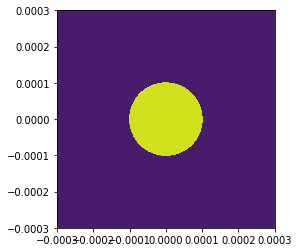

In [21]:
fig, ax = figax()
ax.contourf(x1pts, x1pts, mask)

In [30]:
## compute 1D fft

# pad with zeros for better res in Fourier domain
padding = 1000
mask = zero_pad(mask, padding)
rr = zero_pad(rr, padding)

padmidpt = int(mask.shape[0]/2)
A1x = ifftshift(fft(mask[padmidpt, :]))

# unpad the fields, etc
A1x = A1x[padding:]
A1x = A1x[:-padding]
mask = unpad(mask, padding)
rr = unpad(rr, padding)

I1x = conjugate(A1x)*A1x
I1x/= amax(I1x)
I1x = justify(I1x)

(2001, (2001, 2001), 2001)

('b = 0.0006488633711537092', 2001)

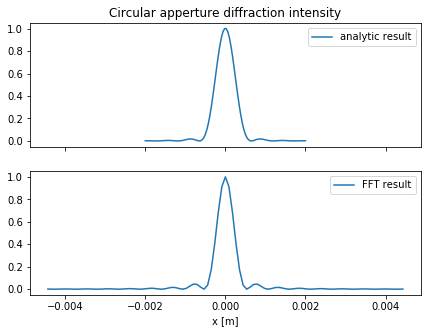

In [36]:
## plot the 1D fft

fig,axes = plt.subplots(2,1, sharey=True, sharex=True, figsize=(7,5))
ax1,ax2 = axes
ax1

# plot the analytic result, up to constant scaling factor
I1_func = lambda x: (j1(a*x*k/f)/x)**2
x2_pts = linspace(-0.002, 0.002, 100)
I1_analytic = I1_func(x2_pts)
I1_analytic /= max(I1_analytic)
ax1.plot(x2_pts, I1_analytic, label='analytic result')
ax1.set_title('Circular apperture diffraction intensity')

start = 950
stop = len(x1pts) - start
# x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f/pts for i in linspace(-pts/2, pts/2, pts)])
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])
ax2.plot(x2pts[start:stop], real(I1x)[start:stop], label='FFT result')
ax2.set_xlabel(r'x [m]')

for ax in axes:
    ax.legend(loc='upper right')

f"b = {b}", len(I1x)

## 4f Imaging with analytic Fourier plane field

In [188]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = 0.7*dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params

w = 4*b # grid half-width
pts = 2000 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

b=0.005031, a=0.0001, dx=0.00043, dy=0.000301, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000049


In [189]:
## compute the Fourier plane field with analytic result

def repeat_phase(x1,y1,dx,dy,xnum,ynum,f1,k):
    """
    The sinusoidal factor appearing in the Fourier plane for an input
    field of x (y) periodicity dx (dy)

    x1,y1: spatial coordinate in the Fourier plane
    dx,dy: periodicity in x,y
    f1: focal length of the lens
    """
    return (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1)))))

field1 = zeros((pts, pts))
t0 = time()
q3_phases = empty((midpt, midpt), complex)
q3 = empty((midpt, midpt), complex)
for i in range(midpt):
    for j in range(midpt):
        q3_phases[i,j] = repeat_phase(x1pts[i], x1pts[j], dx, dy, xnum, ynum, f1, k)
        q3[i,j] = -1j*A0*a*j1(a*rr[i,j]*k/f1)*q3_phases[i,j]/rr[i,j]
print(f"calculated in {time()-t0} s")
field1 = from_quadrant3(q3)

calculated in 13.845118522644043 s


In [190]:
I1_xy = conjugate(field1)*field1

# mask the field - pinhole filter of radius b
mask = circ_mask(rr, b)

# fig, ax = figax()
# cbar = ax.contourf(x1pts, x1pts, (I1_xy*mask)[:pts,:pts])
# fig.colorbar(cbar)
# fig.dpi = 100

In [197]:
## compute the 2D fft in xy plane

# make a phase mask for the fft argument -- this propagates the field a distance z2 from lens f2
prop = lambda z2, f2, rr: exp(-1j*k*rr**2*(z2/f2 - 1)/(2*f2)) # = 1 when z2 = f2

# set z2 from second lens
z2 = f2 - zTalbotx

# pad the field with zeros, as well as any other arrays to be used hereafter.
padding = 100
field1 = zero_pad(field1*mask, padding) # add the mask here too
rr = zero_pad(rr, padding)

t0 = time()
print('f2 - z2 =',f2-z2)
field2 = fftshift(fft2(ifftshift(field1*prop(z2, f2, rr)))) # might need a nyquist mask?
print(f"calculated in {time()-t0} s")

# unpad the fields, etc
field1 = unpad(field1, padding)
field2 = unpad(field2, padding)
rr = unpad(rr, padding)

f2 - z2 = 0.0001008545454545453
calculated in 0.8599481582641602 s


In [198]:
## calculate the output intensity, normalized to intensity in focal plane

# the peak intensity for a bright array may be different based on dx/dy, xnum, ynum, etc
# so anytime you change one of those, run the above cell with z2=f2 to reset the normalization
# constant I2xy_max below before doing subsequent out-of-focus calculations

I2_xy = conjugate(field2)*field2
if f2 - z2 == 0: # will crash if don't run f2-z2 as the first run in the notebook. by design.
    I2xy_max = amax(I2_xy) # so we can always normalize to the focal plane field
    print(f"set the I2xy_max={I2xy_max}")
I2_xy = 1 - I2_xy/I2xy_max #I2xy_max

wrote file to dark_I2xy_z101um_dydx70_10x10.png


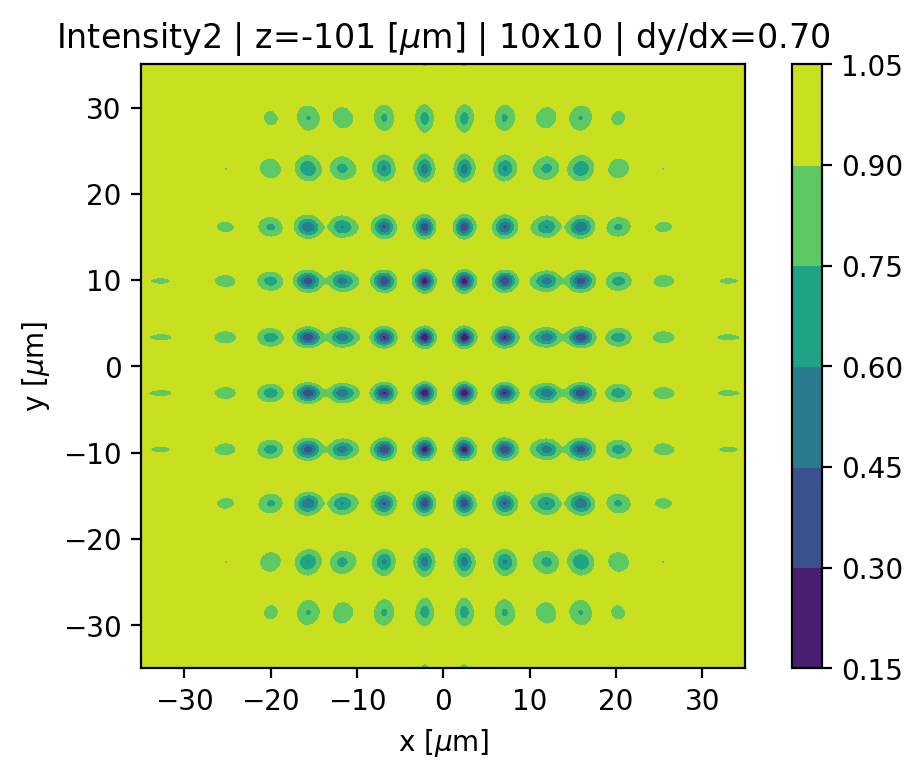

In [199]:
# save file?
savefile=True
fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(100*dy/dx)}_{xnum}x{ynum}.png'

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6
fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
fig.dpi = 200
cbar = ax.contourf(x2pts*scl, x2pts*scl, I2_xy)
fig.colorbar(cbar)
ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')
if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)